In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

FILEMAP = {
    'BTC' : r'../resources/data/raw/BTC_USDT_1m.csv',
    'LINK' : r'../resources/data/raw/LINK_USDT_1m.csv',
    'TRX'  : r'../resources/data/raw/TRX_USDT_1m.csv',
    'ZRX'  : r'../resources/data/raw/ZRX_USDT_1m.csv',
}

COL_PRICE    = 'close'      # ценовата колона в CSV-то
TIMEZONE     = 'UTC'        # всички в UTC
RISK_FREE    = 0.00         # годишен r_f; 0.0 ако не ти трябва
WEIGHT_CAP   = 0.50         # ≤ 50 % в един актив
N_PORTFOLIOS = 25_000       # Монте Карло проби
SEED         = 42
np.random.seed(SEED)

# --- 1-минутни барове → 525 600 на година ----------------------------
BAR_SEC           = 60
PERIODS_PER_YEAR  = int(365 * 86_400 / BAR_SEC) 
print(f'periods_per_year = {PERIODS_PER_YEAR:,}')

periods_per_year = 525,600


In [2]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 1) Зареждане на минутните цени                              ║
# ╚═════════════════════════════════════════════════════════════╝
def load_iso_csv(path: str | Path,
                 price_col: str = COL_PRICE,
                 tz: str = TIMEZONE) -> pd.Series:
    """
    Чете CSV с ISO `timestamp` и връща Series<price> (tz-aware).
    """
    df = pd.read_csv(path,
                     parse_dates=['timestamp'],
                     index_col='timestamp')
    df.index = df.index.tz_localize(tz)
    return df[price_col].astype(float)


# --- комбинираме всички активи ----------------------------------------
prices = pd.concat(
    {tkr: load_iso_csv(p) for tkr, p in FILEMAP.items()},
    axis=1,
    join='inner'                   # пазим минутите, налични за всички
).sort_index()

print(prices.head())

                                BTC   LINK      TRX     ZRX
timestamp                                                  
2023-06-09 12:18:00+00:00  26640.01  6.010  0.07802  0.2008
2023-06-09 12:19:00+00:00  26654.99  6.011  0.07800  0.2011
2023-06-09 12:20:00+00:00  26661.16  6.016  0.07804  0.2012
2023-06-09 12:21:00+00:00  26643.89  6.014  0.07803  0.2009
2023-06-09 12:22:00+00:00  26632.23  6.011  0.07803  0.2008


In [3]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 2) Минутни доходности, μ̅, Σ                                ║
# ╚═════════════════════════════════════════════════════════════╝
rets = prices.pct_change().dropna()

# проверка, че са 1-минутни
freq = rets.index.to_series().diff().dt.total_seconds().median()
assert freq == BAR_SEC, f'Открих {freq=} сек. – не е 1-мин серия!'

means_bar = rets.mean().values                  # μ_i  (за 1 бар)
cov_bar   = rets.cov().values                  # Σ    (за 1 бар)
tickers   = list(FILEMAP.keys())

# кратка статистика
stats = pd.DataFrame({'μ_bar': means_bar,
                      'σ_bar': rets.std(ddof=0).values},
                     index=tickers)
stats['Sharpe_bar'] = stats['μ_bar'] / stats['σ_bar']
display(stats)


,μ_bar,σ_bar,Sharpe_bar
BTC,2.036766e-06,0.000657,0.003098
LINK,2.563369e-06,0.001195,0.002144
TRX,8.000141e-07,0.000439,0.001821
ZRX,2.948866e-06,0.001649,0.001788


In [4]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 3) Монте-Карло портфейли (с ограничение на теглото)         ║
# ╚═════════════════════════════════════════════════════════════╝
n_assets = len(tickers)
results  = np.zeros((3, N_PORTFOLIOS))          # σ, μ, Sharpe
weights  = np.zeros((N_PORTFOLIOS, n_assets))

i = 0
while i < N_PORTFOLIOS:
    w = np.random.random(n_assets)
    w /= w.sum()
    if (w > WEIGHT_CAP).any():          # концентрационен лимит
        continue

    mu_bar  = np.dot(w, means_bar)
    sig_bar = np.sqrt(w @ cov_bar @ w)

    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)

    weights[i]   = w
    results[0,i] = sig_ann
    results[1,i] = mu_ann
    results[2,i] = (mu_ann - RISK_FREE) / sig_ann

    i += 1

idx_max_sharpe = results[2].argmax()
idx_min_vol    = results[0].argmin()


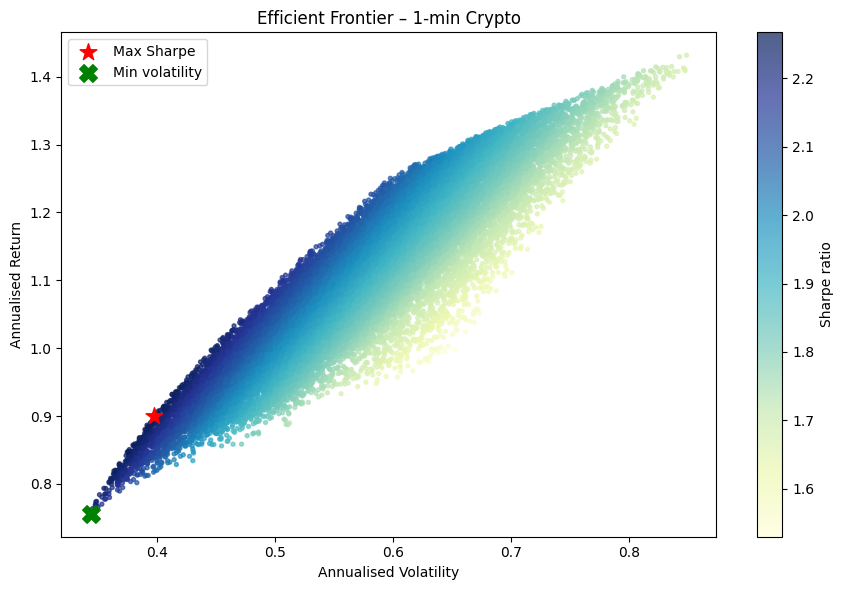

In [5]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 4) Графика: Efficient Frontier                             ║
# ╚═════════════════════════════════════════════════════════════╝
fig, ax = plt.subplots(figsize=(9, 6))
sc = ax.scatter(results[0], results[1],
                c=results[2], cmap='YlGnBu', s=8, alpha=0.7)
fig.colorbar(sc, label='Sharpe ratio')

ax.scatter(*results[:2, idx_max_sharpe],
           marker='*', s=160, color='r', label='Max Sharpe')
ax.scatter(*results[:2, idx_min_vol],
           marker='X', s=160, color='g', label='Min volatility')

ax.set(title='Efficient Frontier – 1-min Crypto',
       xlabel='Annualised Volatility',
       ylabel='Annualised Return')
ax.legend(); plt.tight_layout()


In [6]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 5) Показване на разпределенията                             ║
# ╚═════════════════════════════════════════════════════════════╝
alloc_max = pd.Series(weights[idx_max_sharpe], index=tickers).round(2)
alloc_min = pd.Series(weights[idx_min_vol   ], index=tickers).round(2)

print('\n' + '─'*70)
print('ПОРТФЕЙЛ С МАКС. SHARPE')
print(f"  Год. доходност : {results[1, idx_max_sharpe]:.2%}")
print(f"  Год. волатилност : {results[0, idx_max_sharpe]:.2%}\n")
display(alloc_max.to_frame('Weight').T)

print('\n' + '─'*70)
print('ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ')
print(f"  Год. доходност : {results[1, idx_min_vol]:.2%}")
print(f"  Год. волатилност : {results[0, idx_min_vol]:.2%}\n")
display(alloc_min.to_frame('Weight').T)



──────────────────────────────────────────────────────────────────────
ПОРТФЕЙЛ С МАКС. SHARPE
  Год. доходност : 90.00%
  Год. волатилност : 39.70%



,BTC,LINK,TRX,ZRX
Weight,0.5,0.06,0.35,0.09



──────────────────────────────────────────────────────────────────────
ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ
  Год. доходност : 75.60%
  Год. волатилност : 34.38%



,BTC,LINK,TRX,ZRX
Weight,0.48,0.02,0.49,0.0


In [7]:
# ╔═════════════════════════════════════════════════════════════╗
# ║ 6) Генетичен алгоритъм – оптимизация на Sharpe              ║
# ╚═════════════════════════════════════════════════════════════╝
import random

# --------------------------------------------------------------
# Хиперпараметри на GA
# --------------------------------------------------------------
POP_SIZE       = 1000          # колко индивида във всяко поколение
NB_GENERATIONS = 50             # колко поколения
ELITE_FRAC     = 0.10           # най-добрият % индивиди, които копираме директно
MUTATE_FRAC    = 0.15           # шанс дадено дете да бъде мутант
MUTATE_SCALE   = 0.10           # колко силно „рита“ мутантът теглото
PLOT_X = 5
PLOT_Y = 5


np.random.seed(123)

# --------------------------------------------------------------
# Фитнес функция – годишен Sharpe
# --------------------------------------------------------------
def fitness(w: np.ndarray) -> float:
    """
    w трябва вече да е нормализиран: Σ w_i = 1
    """
    mu_bar  = w @ means_bar
    sig_bar = np.sqrt(w @ cov_bar @ w)
    
    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)
    return (mu_ann - RISK_FREE) / sig_ann


# --------------------------------------------------------------
# GA инструменти: кросоувър, мутация, създаване на поколение
# --------------------------------------------------------------
def crossover(p1: np.ndarray, p2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Симпъл α-crossover (α ~ U[0,1])
    """
    α = np.random.rand()
    c1 = α * p1 + (1 - α) * p2
    c2 = (1 - α) * p1 + α * p2
    return c1, c2

def mutate(child: np.ndarray) -> np.ndarray:
    """
    Избутва случайно тегло с N(0, MUTATE_SCALE).
    После нормализира и реже до WEIGHT_CAP.
    """
    idx = np.random.randint(len(child))
    child[idx] += np.random.normal(0, MUTATE_SCALE)
    child = np.clip(child, 0, WEIGHT_CAP)      # защитно изрязване
    child /= child.sum()
    return child

def next_generation(pop: list[np.ndarray]) -> list[np.ndarray]:
    """
    Създава следващото поколение:
      1. сортира по fitness (низходящ)
      2. взема ELITE_FRAC като “елит”
      3. прави деца чрез кросоувър
      4. мутира част от децата
      5. нормализира теглата
    """
    pop = sorted(pop, key=fitness, reverse=True)
    elite_n = int(len(pop) * ELITE_FRAC)
    new_pop = pop[:elite_n]                       # запазваме елита
    
    # ––– рандомизираме елита, за да правим случайни двойки
    random.shuffle(new_pop)
    parents = new_pop.copy()
    
    # ––– кросоувър
    children = []
    for p1, p2 in zip(parents[::2], parents[1::2]):
        c1, c2 = crossover(p1, p2)
        children.extend([c1, c2])
    
    # ––– мутации
    for k in range(len(children)):
        if np.random.rand() < MUTATE_FRAC:
            children[k] = mutate(children[k])
        # задължителна нормализация + cap
        children[k] = np.clip(children[k], 0, WEIGHT_CAP)
        children[k] /= children[k].sum()
    
    new_pop.extend(children)
    
    # ако популацията е недостатъчна (нечетен брой родители)
    while len(new_pop) < POP_SIZE:
        w = np.random.random(len(tickers))
        w /= w.sum()
        if (w > WEIGHT_CAP).any():
            continue
        new_pop.append(w)
    return new_pop[:POP_SIZE]


# hyperparameters optimizer
import numpy as np, random, math, optuna, time
from copy import deepcopy
def run_ga_once(pop_size, nb_generations, elite_frac,
                mutate_frac, mutate_scale,
                weight_cap, seed=None):
    """
    Стартира ЕДНО изпълнение на GA с подадените хиперпараметри.
    Връща Sharpe на най-добрия индивид.
    """

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # -------------- локални override-и на глобалните константи --------------
    global POP_SIZE, NB_GENERATIONS, ELITE_FRAC
    global MUTATE_FRAC, MUTATE_SCALE, WEIGHT_CAP

    POP_SIZE       = pop_size
    NB_GENERATIONS = nb_generations
    ELITE_FRAC     = elite_frac
    MUTATE_FRAC    = mutate_frac
    MUTATE_SCALE   = mutate_scale
    WEIGHT_CAP     = weight_cap          # нов параметър!

    # -------------- инициализираме първото поколение ------------------------
    population = []
    while len(population) < POP_SIZE:
        w = np.random.random(len(tickers))
        w /= w.sum()
        if (w > WEIGHT_CAP).any():
            continue
        population.append(w)

    # -------------- еволюираме ----------------------------------------------
    best_fit = -math.inf
    for g in range(NB_GENERATIONS):
        population = next_generation(population)
        # оценяваме елита
        top = max(population, key=fitness)
        best_fit = max(best_fit, fitness(top))

    return best_fit   # ↑ Sharpe на най-силния индивид

def objective(trial: optuna.trial.Trial) -> float:
    """
    Optuna ще пробва различни GA-хиперпараметри и ще
    връща >>средния<< Sharpe от K рестарта на GA.
    """
    # 1) дефинираме търсено пространство
    pop_size       = trial.suggest_int   ('pop_size',        200, 1500, step=100)
    nb_generations = trial.suggest_int   ('nb_generations',   20, 200,  step=10)
    elite_frac     = trial.suggest_float ('elite_frac',      0.05, 0.35)
    mutate_frac    = trial.suggest_float ('mutate_frac',     0.05, 0.40)
    mutate_scale   = trial.suggest_float ('mutate_scale',    0.01, 0.50, log=True)
    weight_cap     = trial.suggest_float ('weight_cap',      0.30, 0.70)

    # 2) за стабилност ‒ стартираме GA K пъти с разл. seed
    K, scores = 3, []
    for k in range(K):
        seed = 2024 + k
        score = run_ga_once(pop_size, nb_generations,
                            elite_frac, mutate_frac, mutate_scale,
                            weight_cap, seed=seed)
        scores.append(score)

    # 3) Optuna максимизира -> връщаме средната стойност
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner =optuna.pruners.MedianPruner(
                                        n_startup_trials=10, n_warmup_steps=5))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
study.optimize(objective,
               n_trials = 40,          # или по време: timeout=3600
               show_progress_bar=True)

print("🏆 Най-добрите GA-хиперпараметри:")
for k, v in study.best_trial.params.items():
    print(f"  {k:15s} : {v}")
print("Среден Sharpe  :", study.best_value)




/home/npenchev/fun/summer-school-2025-crypto-forecasting/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-27 22:01:57,396] A new study created in memory with name: no-name-74614448-712c-4d2a-b09f-de20b36573ab
Best trial: 0. Best value: 2.28895:   2%|██▉                                                                                                                 | 1/40 [00:14<09:06, 14.02s/it]

[I 2025-06-27 22:02:11,419] Trial 0 finished with value: 2.288952247296682 and parameters: {'pop_size': 1500, 'nb_generations': 110, 'elite_frac': 0.09780352430087787, 'mutate_frac': 0.17816035234705785, 'mutate_scale': 0.03937867380749903, 'weight_cap': 0.5277896841693224}. Best is trial 0 with value: 2.288952247296682.


Best trial: 1. Best value: 2.31039:   5%|█████▊                                                                                                              | 2/40 [00:20<06:02,  9.55s/it]

[I 2025-06-27 22:02:17,844] Trial 1 finished with value: 2.3103879708344652 and parameters: {'pop_size': 1500, 'nb_generations': 50, 'elite_frac': 0.13301065347796637, 'mutate_frac': 0.3434983206652151, 'mutate_scale': 0.3220214351735864, 'weight_cap': 0.6726454723052014}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 1. Best value: 2.31039:   8%|████████▋                                                                                                           | 3/40 [00:29<05:49,  9.45s/it]

[I 2025-06-27 22:02:27,183] Trial 2 finished with value: 2.3076264301881886 and parameters: {'pop_size': 1500, 'nb_generations': 70, 'elite_frac': 0.12786859797997957, 'mutate_frac': 0.2039614390140837, 'mutate_scale': 0.08209707990281764, 'weight_cap': 0.6234181321163419}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 1. Best value: 2.31039:  10%|███████████▌                                                                                                        | 4/40 [00:49<08:12, 13.69s/it]

[I 2025-06-27 22:02:47,356] Trial 3 finished with value: 2.1873762200356546 and parameters: {'pop_size': 1000, 'nb_generations': 150, 'elite_frac': 0.1462834173297069, 'mutate_frac': 0.1463886517037108, 'mutate_scale': 0.011054299846926307, 'weight_cap': 0.36021413776418165}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 1. Best value: 2.31039:  12%|██████████████▌                                                                                                     | 5/40 [00:51<05:29,  9.42s/it]

[I 2025-06-27 22:02:49,214] Trial 4 finished with value: 2.2777780375159176 and parameters: {'pop_size': 400, 'nb_generations': 50, 'elite_frac': 0.3128627198658071, 'mutate_frac': 0.1995175024814031, 'mutate_scale': 0.18892380234308678, 'weight_cap': 0.49038979858400134}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 1. Best value: 2.31039:  15%|█████████████████▍                                                                                                  | 6/40 [01:19<08:55, 15.76s/it]

[I 2025-06-27 22:03:17,273] Trial 5 finished with value: 2.2386762839637595 and parameters: {'pop_size': 1300, 'nb_generations': 200, 'elite_frac': 0.10637410242371949, 'mutate_frac': 0.06390185831565233, 'mutate_scale': 0.025567853100082104, 'weight_cap': 0.3999997830892388}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 1. Best value: 2.31039:  18%|████████████████████▎                                                                                               | 7/40 [01:28<07:18, 13.29s/it]

[I 2025-06-27 22:03:25,492] Trial 6 finished with value: 2.2960047586806334 and parameters: {'pop_size': 600, 'nb_generations': 150, 'elite_frac': 0.19992749482558958, 'mutate_frac': 0.06409963702537722, 'mutate_scale': 0.014017082473853254, 'weight_cap': 0.5702306750459905}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 1. Best value: 2.31039:  20%|███████████████████████▏                                                                                            | 8/40 [01:33<05:45, 10.79s/it]

[I 2025-06-27 22:03:30,912] Trial 7 finished with value: 2.2951430252413396 and parameters: {'pop_size': 800, 'nb_generations': 80, 'elite_frac': 0.33867640042423125, 'mutate_frac': 0.19348937061636062, 'mutate_scale': 0.26521049227200044, 'weight_cap': 0.536572210475454}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 1. Best value: 2.31039:  22%|██████████████████████████                                                                                          | 9/40 [01:36<04:20,  8.41s/it]

[I 2025-06-27 22:03:34,096] Trial 8 finished with value: 2.1794172644142424 and parameters: {'pop_size': 300, 'nb_generations': 40, 'elite_frac': 0.05480072437666166, 'mutate_frac': 0.16088966271544186, 'mutate_scale': 0.07119684571905537, 'weight_cap': 0.32309500846398936}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 1. Best value: 2.31039:  25%|████████████████████████████▊                                                                                      | 10/40 [01:58<06:16, 12.55s/it]

[I 2025-06-27 22:03:55,905] Trial 9 finished with value: 2.245307247414314 and parameters: {'pop_size': 1500, 'nb_generations': 130, 'elite_frac': 0.3153182848180099, 'mutate_frac': 0.3980657782088751, 'mutate_scale': 0.06465525711752844, 'weight_cap': 0.38975081561901037}. Best is trial 1 with value: 2.3103879708344652.


Best trial: 10. Best value: 2.31053:  28%|███████████████████████████████▎                                                                                  | 11/40 [02:00<04:30,  9.34s/it]

[I 2025-06-27 22:03:57,964] Trial 10 finished with value: 2.310530017566233 and parameters: {'pop_size': 1100, 'nb_generations': 20, 'elite_frac': 0.24975522808447415, 'mutate_frac': 0.3535727493187389, 'mutate_scale': 0.4656148097915095, 'weight_cap': 0.6940566167832998}. Best is trial 10 with value: 2.310530017566233.


Best trial: 11. Best value: 2.31055:  30%|██████████████████████████████████▏                                                                               | 12/40 [02:02<03:18,  7.07s/it]

[I 2025-06-27 22:03:59,861] Trial 11 finished with value: 2.310546341062104 and parameters: {'pop_size': 1100, 'nb_generations': 20, 'elite_frac': 0.24899964407506903, 'mutate_frac': 0.3568247260039509, 'mutate_scale': 0.47910550949225034, 'weight_cap': 0.6994270278458621}. Best is trial 11 with value: 2.310546341062104.


Best trial: 12. Best value: 2.31063:  32%|█████████████████████████████████████                                                                             | 13/40 [02:04<02:31,  5.60s/it]

[I 2025-06-27 22:04:02,061] Trial 12 finished with value: 2.310632987520226 and parameters: {'pop_size': 1100, 'nb_generations': 20, 'elite_frac': 0.2522496975608299, 'mutate_frac': 0.2935234035949816, 'mutate_scale': 0.48447084224442594, 'weight_cap': 0.6908468010465865}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  35%|███████████████████████████████████████▉                                                                          | 14/40 [02:06<01:58,  4.56s/it]

[I 2025-06-27 22:04:04,237] Trial 13 finished with value: 2.3077155368802273 and parameters: {'pop_size': 1100, 'nb_generations': 20, 'elite_frac': 0.250735982645579, 'mutate_frac': 0.27293657689946227, 'mutate_scale': 0.14624103095815547, 'weight_cap': 0.6267700035675537}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  38%|██████████████████████████████████████████▊                                                                       | 15/40 [02:13<02:12,  5.28s/it]

[I 2025-06-27 22:04:11,194] Trial 14 finished with value: 2.307109175427481 and parameters: {'pop_size': 800, 'nb_generations': 90, 'elite_frac': 0.22987665570625404, 'mutate_frac': 0.2727925980352911, 'mutate_scale': 0.48690309567472284, 'weight_cap': 0.6226726441444784}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  40%|█████████████████████████████████████████████▌                                                                    | 16/40 [02:16<01:44,  4.37s/it]

[I 2025-06-27 22:04:13,435] Trial 15 finished with value: 2.3104731557429568 and parameters: {'pop_size': 1200, 'nb_generations': 20, 'elite_frac': 0.19383061242202557, 'mutate_frac': 0.28416891137615063, 'mutate_scale': 0.1354954654448241, 'weight_cap': 0.6994603654646013}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  42%|████████████████████████████████████████████████▍                                                                 | 17/40 [02:21<01:49,  4.74s/it]

[I 2025-06-27 22:04:19,038] Trial 16 finished with value: 2.2666191982145416 and parameters: {'pop_size': 900, 'nb_generations': 60, 'elite_frac': 0.2819417709756082, 'mutate_frac': 0.3141448020328794, 'mutate_scale': 0.2858896147384021, 'weight_cap': 0.4432174628633698}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  45%|███████████████████████████████████████████████████▎                                                              | 18/40 [02:32<02:26,  6.65s/it]

[I 2025-06-27 22:04:30,126] Trial 17 finished with value: 2.304491148599876 and parameters: {'pop_size': 600, 'nb_generations': 190, 'elite_frac': 0.17223260214446867, 'mutate_frac': 0.39648594574998886, 'mutate_scale': 0.2145429304144265, 'weight_cap': 0.5839706322492191}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  48%|██████████████████████████████████████████████████████▏                                                           | 19/40 [02:45<03:01,  8.62s/it]

[I 2025-06-27 22:04:43,349] Trial 18 finished with value: 2.3102091333280135 and parameters: {'pop_size': 1300, 'nb_generations': 100, 'elite_frac': 0.27755265291815906, 'mutate_frac': 0.23582471150746315, 'mutate_scale': 0.4977594753139049, 'weight_cap': 0.6610001913574544}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  50%|█████████████████████████████████████████████████████████                                                         | 20/40 [02:48<02:15,  6.78s/it]

[I 2025-06-27 22:04:45,818] Trial 19 finished with value: 2.308989048882372 and parameters: {'pop_size': 600, 'nb_generations': 40, 'elite_frac': 0.21927969713338388, 'mutate_frac': 0.3280616636430216, 'mutate_scale': 0.13201098290098157, 'weight_cap': 0.6395038247512874}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  52%|███████████████████████████████████████████████████████████▊                                                      | 21/40 [02:52<01:52,  5.92s/it]

[I 2025-06-27 22:04:49,734] Trial 20 finished with value: 2.307907689636403 and parameters: {'pop_size': 1300, 'nb_generations': 30, 'elite_frac': 0.27834909982212536, 'mutate_frac': 0.3608992868359018, 'mutate_scale': 0.33470883016589736, 'weight_cap': 0.5874518960065551}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  55%|██████████████████████████████████████████████████████████████▋                                                   | 22/40 [02:54<01:26,  4.83s/it]

[I 2025-06-27 22:04:52,039] Trial 21 finished with value: 2.3104614144207916 and parameters: {'pop_size': 1100, 'nb_generations': 20, 'elite_frac': 0.2454076110504692, 'mutate_frac': 0.36520753784763876, 'mutate_scale': 0.4056029623257563, 'weight_cap': 0.6875589264650181}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  57%|█████████████████████████████████████████████████████████████████▌                                                | 23/40 [03:00<01:26,  5.07s/it]

[I 2025-06-27 22:04:57,652] Trial 22 finished with value: 2.310163130694298 and parameters: {'pop_size': 900, 'nb_generations': 60, 'elite_frac': 0.2565059408190628, 'mutate_frac': 0.3023987158193799, 'mutate_scale': 0.22208319797421144, 'weight_cap': 0.6587918567119804}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  60%|████████████████████████████████████████████████████████████████████▍                                             | 24/40 [03:05<01:20,  5.03s/it]

[I 2025-06-27 22:05:02,596] Trial 23 finished with value: 2.310484472068914 and parameters: {'pop_size': 1100, 'nb_generations': 40, 'elite_frac': 0.3020912155299515, 'mutate_frac': 0.24420043971966224, 'mutate_scale': 0.36897423467963525, 'weight_cap': 0.6908371127425668}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  62%|███████████████████████████████████████████████████████████████████████▎                                          | 25/40 [03:07<01:03,  4.25s/it]

[I 2025-06-27 22:05:05,023] Trial 24 finished with value: 2.309034515091049 and parameters: {'pop_size': 1000, 'nb_generations': 20, 'elite_frac': 0.21937765938385173, 'mutate_frac': 0.3602075926742163, 'mutate_scale': 0.49399028236235193, 'weight_cap': 0.6120693852452954}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  65%|██████████████████████████████████████████████████████████████████████████                                        | 26/40 [03:15<01:15,  5.42s/it]

[I 2025-06-27 22:05:13,148] Trial 25 finished with value: 2.309707334745594 and parameters: {'pop_size': 1200, 'nb_generations': 70, 'elite_frac': 0.17754835586454185, 'mutate_frac': 0.3278170182422888, 'mutate_scale': 0.09804392094274104, 'weight_cap': 0.6528006570545801}. Best is trial 12 with value: 2.310632987520226.


Best trial: 12. Best value: 2.31063:  68%|████████████████████████████████████████████████████████████████████████████▉                                     | 27/40 [03:19<01:04,  4.97s/it]

[I 2025-06-27 22:05:17,080] Trial 26 finished with value: 2.276595143608113 and parameters: {'pop_size': 1000, 'nb_generations': 30, 'elite_frac': 0.26343107171935537, 'mutate_frac': 0.2961369730223795, 'mutate_scale': 0.17998122623155402, 'weight_cap': 0.4712731580299576}. Best is trial 12 with value: 2.310632987520226.


Best trial: 27. Best value: 2.31063:  70%|███████████████████████████████████████████████████████████████████████████████▊                                  | 28/40 [03:23<00:56,  4.67s/it]

[I 2025-06-27 22:05:21,059] Trial 27 finished with value: 2.3106333897420552 and parameters: {'pop_size': 700, 'nb_generations': 50, 'elite_frac': 0.34249724978684576, 'mutate_frac': 0.3793673787601312, 'mutate_scale': 0.2539800937602555, 'weight_cap': 0.6994412725517846}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  72%|██████████████████████████████████████████████████████████████████████████████████▋                               | 29/40 [03:27<00:49,  4.51s/it]

[I 2025-06-27 22:05:25,186] Trial 28 finished with value: 2.301056577267429 and parameters: {'pop_size': 700, 'nb_generations': 50, 'elite_frac': 0.34456649395792244, 'mutate_frac': 0.3793160255999237, 'mutate_scale': 0.26271017134810265, 'weight_cap': 0.5501220121698677}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  75%|█████████████████████████████████████████████████████████████████████████████████████▌                            | 30/40 [03:32<00:46,  4.70s/it]

[I 2025-06-27 22:05:30,327] Trial 29 finished with value: 2.3053401714618555 and parameters: {'pop_size': 500, 'nb_generations': 100, 'elite_frac': 0.3295392107568563, 'mutate_frac': 0.25678312915327295, 'mutate_scale': 0.050046732048174856, 'weight_cap': 0.5935533928596746}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  78%|████████████████████████████████████████████████████████████████████████████████████████▎                         | 31/40 [03:40<00:50,  5.57s/it]

[I 2025-06-27 22:05:37,924] Trial 30 finished with value: 2.309148497533591 and parameters: {'pop_size': 700, 'nb_generations': 120, 'elite_frac': 0.2920490568037399, 'mutate_frac': 0.32462448050340525, 'mutate_scale': 0.02178295330028513, 'weight_cap': 0.650229665685999}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 32/40 [03:44<00:39,  4.97s/it]

[I 2025-06-27 22:05:41,511] Trial 31 finished with value: 2.310539977373795 and parameters: {'pop_size': 1200, 'nb_generations': 30, 'elite_frac': 0.22883167036788762, 'mutate_frac': 0.3479478276306221, 'mutate_scale': 0.39191668393185936, 'weight_cap': 0.6969977197504273}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  82%|██████████████████████████████████████████████████████████████████████████████████████████████                    | 33/40 [03:49<00:34,  4.95s/it]

[I 2025-06-27 22:05:46,403] Trial 32 finished with value: 2.310285134884032 and parameters: {'pop_size': 1200, 'nb_generations': 40, 'elite_frac': 0.2257053712364474, 'mutate_frac': 0.3782107954007785, 'mutate_scale': 0.3633753537545189, 'weight_cap': 0.6749295090626447}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  85%|████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 34/40 [03:56<00:34,  5.72s/it]

[I 2025-06-27 22:05:53,920] Trial 33 finished with value: 2.3101147144233916 and parameters: {'pop_size': 1400, 'nb_generations': 60, 'elite_frac': 0.1639646095896915, 'mutate_frac': 0.3410540755383855, 'mutate_scale': 0.2879314124586275, 'weight_cap': 0.6655663846417375}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▊              | 35/40 [04:00<00:26,  5.24s/it]

[I 2025-06-27 22:05:58,037] Trial 34 finished with value: 2.310516575182992 and parameters: {'pop_size': 1400, 'nb_generations': 30, 'elite_frac': 0.20641735262300126, 'mutate_frac': 0.34486033592948434, 'mutate_scale': 0.37308383859561955, 'weight_cap': 0.6979853814615772}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 36/40 [04:01<00:16,  4.00s/it]

[I 2025-06-27 22:05:59,152] Trial 35 finished with value: 2.3062731159510848 and parameters: {'pop_size': 200, 'nb_generations': 50, 'elite_frac': 0.23289034508922904, 'mutate_frac': 0.3798492492379119, 'mutate_scale': 0.24703843070539075, 'weight_cap': 0.6090234558769217}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 37/40 [04:08<00:14,  4.77s/it]

[I 2025-06-27 22:06:05,707] Trial 36 finished with value: 2.3102767490885614 and parameters: {'pop_size': 900, 'nb_generations': 70, 'elite_frac': 0.3180827727777953, 'mutate_frac': 0.3057699487133961, 'mutate_scale': 0.17879938608050783, 'weight_cap': 0.6717630694840392}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 38/40 [04:10<00:08,  4.14s/it]

[I 2025-06-27 22:06:08,397] Trial 37 finished with value: 2.307451239245658 and parameters: {'pop_size': 1000, 'nb_generations': 30, 'elite_frac': 0.14382784111687058, 'mutate_frac': 0.09569303938322396, 'mutate_scale': 0.10327969608716027, 'weight_cap': 0.6362985034310269}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 39/40 [04:18<00:05,  5.16s/it]

[I 2025-06-27 22:06:15,937] Trial 38 finished with value: 2.2861878042838133 and parameters: {'pop_size': 800, 'nb_generations': 80, 'elite_frac': 0.11013402537734131, 'mutate_frac': 0.340682443779759, 'mutate_scale': 0.3058195523359456, 'weight_cap': 0.5065290559356527}. Best is trial 27 with value: 2.3106333897420552.


Best trial: 27. Best value: 2.31063: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:40<00:00,  7.02s/it]

[I 2025-06-27 22:06:38,290] Trial 39 finished with value: 2.3018696531472327 and parameters: {'pop_size': 1400, 'nb_generations': 160, 'elite_frac': 0.27174902517397087, 'mutate_frac': 0.20937143350545745, 'mutate_scale': 0.40353182478727473, 'weight_cap': 0.5589278921397054}. Best is trial 27 with value: 2.3106333897420552.
🏆 Най-добрите GA-хиперпараметри:
  pop_size        : 700
  nb_generations  : 50
  elite_frac      : 0.34249724978684576
  mutate_frac     : 0.3793673787601312
  mutate_scale    : 0.2539800937602555
  weight_cap      : 0.6994412725517846
Среден Sharpe  : 2.3106333897420552


In [8]:
    # POP_SIZE       = pop_size
    # NB_GENERATIONS = nb_generations
    # ELITE_FRAC     = elite_frac
    # MUTATE_FRAC    = mutate_frac
    # MUTATE_SCALE   = mutate_scale
    # WEIGHT_CAP     = weight_cap 
print("OPTIMIZED HYPERPARAMETERS")
print(f"POP_SIZE: {POP_SIZE}")
print(f"NB_GENERATIONS: {NB_GENERATIONS}")
print(f"ELITE_FRAC: {ELITE_FRAC}")
print(f"MUTATE_FRAC: {MUTATE_FRAC}")
print(f"MUTATE_SCALE: {MUTATE_SCALE}")
print(f"WEIGHT_CAP: {WEIGHT_CAP}")

OPTIMIZED HYPERPARAMETERS
POP_SIZE: 1400
NB_GENERATIONS: 160
ELITE_FRAC: 0.27174902517397087
MUTATE_FRAC: 0.20937143350545745
MUTATE_SCALE: 0.40353182478727473
WEIGHT_CAP: 0.5589278921397054


Ще се визуализират поколения: [0, 6, 13, 19, 26, 33, 39, 46, 53, 59, 66, 72, 79, 86, 92, 99, 106, 112, 119, 125, 132, 139, 145, 152, 159]


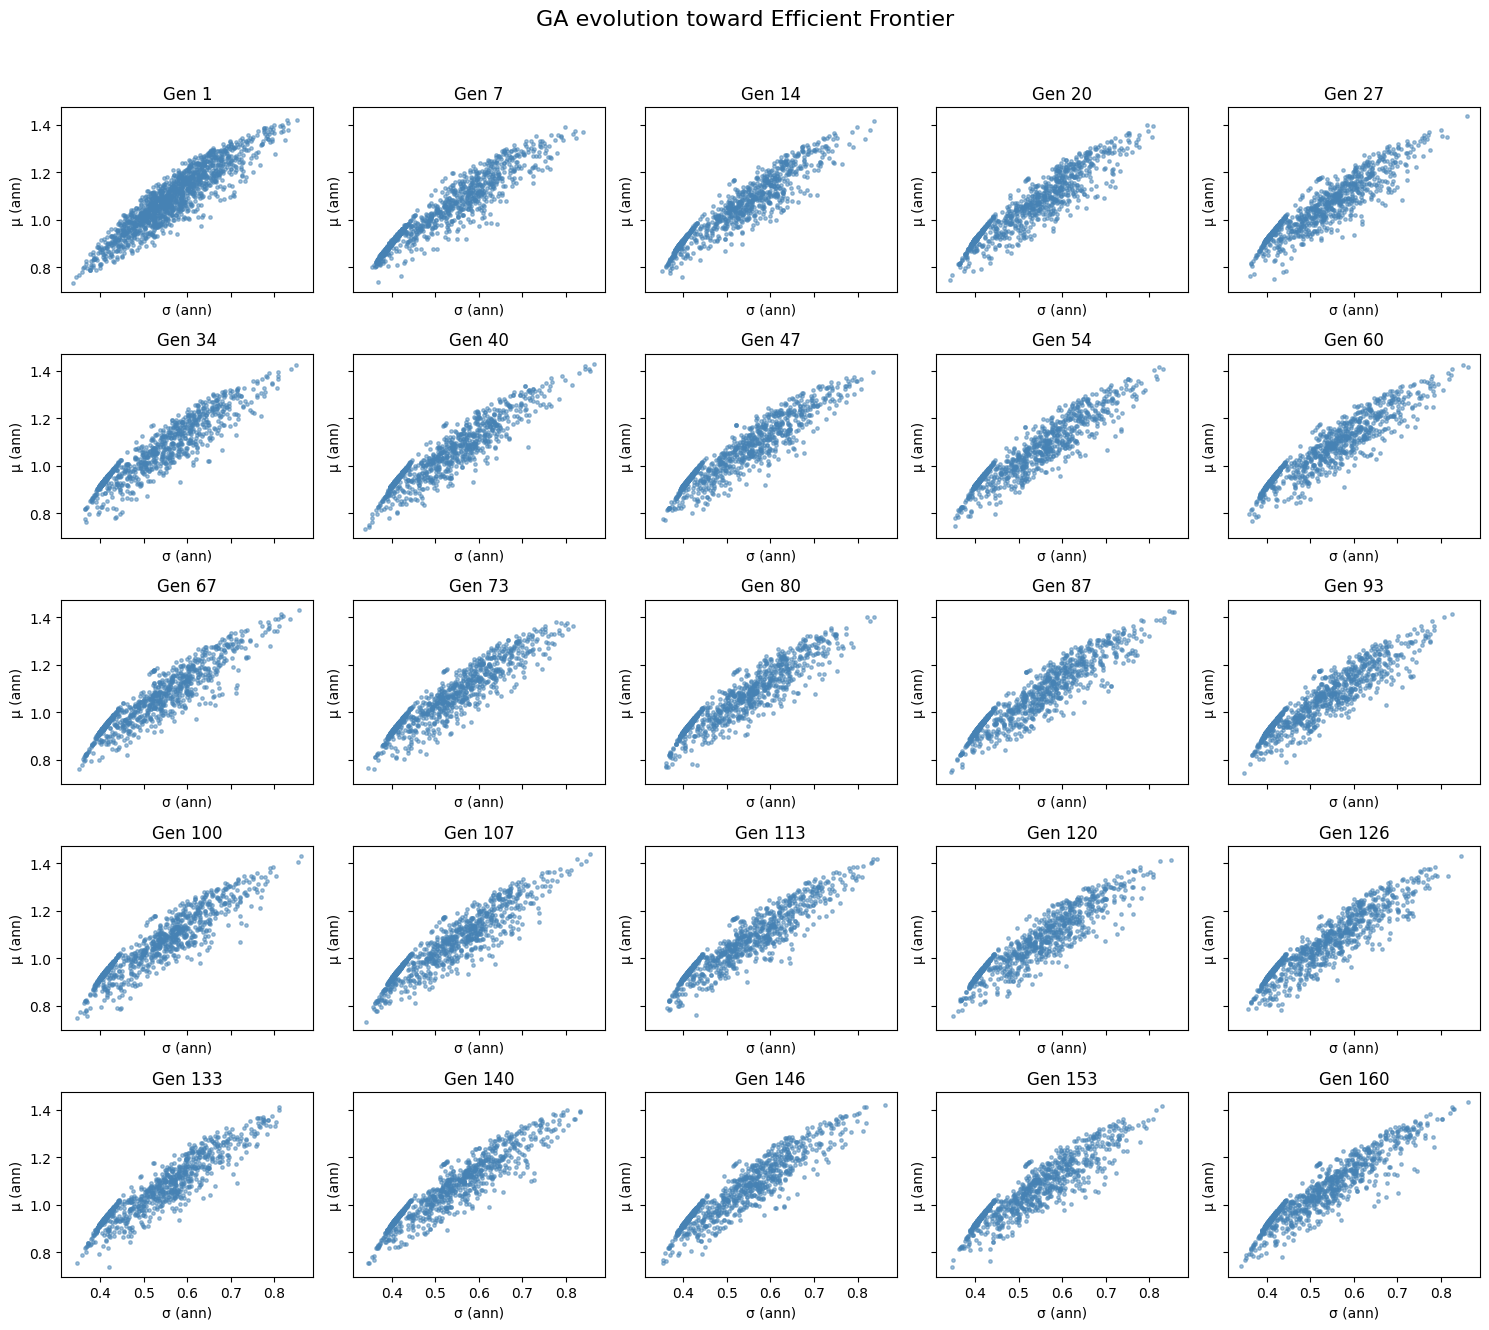

In [9]:
# --------------------------------------------------------------
# 6.1) Инициализация на първото поколение
# --------------------------------------------------------------
population = []
while len(population) < POP_SIZE:
    w = np.random.random(len(tickers))
    w /= w.sum()
    if (w > WEIGHT_CAP).any():
        continue
    population.append(w)

# --------------------------------------------------------------
# 6.2) Еволюция и визуализация
# --------------------------------------------------------------
# fig, axs = plt.subplots(PLOT_X, PLOT_Y, figsize=(15, 13), sharex=True, sharey=True)
# axs = axs.flatten()

fig, axs = plt.subplots(PLOT_Y, PLOT_X, figsize=(15, 13),
                        sharex=True, sharey=True)
axs = axs.flatten()
MAX_PLOTS = PLOT_X * PLOT_Y      # 25

# кои поколения ще рисуваме
if NB_GENERATIONS <= MAX_PLOTS:
    gens_to_plot = list(range(NB_GENERATIONS))
else:
    # равномерни индекси, винаги включва 0
    gens_to_plot = (np.linspace(0, NB_GENERATIONS - 1,
                                num=MAX_PLOTS, dtype=int)
                      .tolist())

print("Ще се визуализират поколения:", gens_to_plot)

for g in range(NB_GENERATIONS):
    # ── статистика за текущото поколение ───────────────────────
    res = np.zeros((2, POP_SIZE))            # σ, μ  (годишни)
    for i, w in enumerate(population):
        mu_bar  = w @ means_bar
        sig_bar = np.sqrt(w @ cov_bar @ w)
        res[1, i] = mu_bar  * PERIODS_PER_YEAR
        res[0, i] = sig_bar * np.sqrt(PERIODS_PER_YEAR)

    # ── чертаем само ако g e в списъка ──────────────────────────
    if g in gens_to_plot:
        plot_idx = gens_to_plot.index(g)     # 0 … 24
        ax = axs[plot_idx]
        ax.scatter(res[0], res[1], s=6, alpha=0.5, c='steelblue')
        ax.set_title(f'Gen {g+1}')
        ax.set_xlabel('σ (ann)')
        ax.set_ylabel('μ (ann)')

    # ── еволюираме към следващо поколение ───────────────────────
    population = next_generation(population)

plt.suptitle('GA evolution toward Efficient Frontier', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [11]:
TOP_N = 20        # how many best portfolios you want to list

def ann_stats(w: np.ndarray) -> tuple[float, float, float]:
    mu_bar  = w @ means_bar
    sig_bar = np.sqrt(w @ cov_bar @ w)
    mu_ann  = mu_bar  * PERIODS_PER_YEAR
    sig_ann = sig_bar * np.sqrt(PERIODS_PER_YEAR)
    sharpe  = (mu_ann - RISK_FREE) / sig_ann
    return mu_ann, sig_ann, sharpe

# 1) take the best TOP_N by Sharpe
best_pop = sorted(population, key=fitness, reverse=True)[:TOP_N]

# 2) build one combined table
records = []
for rank, w in enumerate(best_pop, 1):
    mu, sig, shp = ann_stats(w)
    rec = {
        'Rank'      : rank,
        'Annual μ'  : round(mu, 4),
        'Annual σ'  : round(sig, 4),
        'Sharpe'    : round(shp, 3)
    }
    # add the weights, rounded to 3 dp
    rec.update({tkr: round(w[i], 3) for i, tkr in enumerate(tickers)})
    records.append(rec)

top_df = (pd.DataFrame(records)
            .set_index('Rank')
            .sort_index())

display(top_df)


,Annual μ,Annual σ,Sharpe,BTC,LINK,TRX,ZRX
Rank,,,,,,,
1,0.9727,0.4224,2.303,0.637,0.067,0.229,0.067
2,1.0165,0.4421,2.299,0.663,0.069,0.179,0.090
3,0.9752,0.4244,2.298,0.618,0.064,0.235,0.083
4,0.9962,0.4335,2.298,0.654,0.039,0.206,0.101
5,0.9722,0.4231,2.298,0.614,0.072,0.238,0.076
6,0.9381,0.4083,2.298,0.614,0.021,0.277,0.088
7,0.9508,0.4139,2.297,0.600,0.057,0.266,0.078
8,0.9615,0.4185,2.297,0.606,0.061,0.253,0.080
9,0.9578,0.4169,2.297,0.605,0.053,0.258,0.084


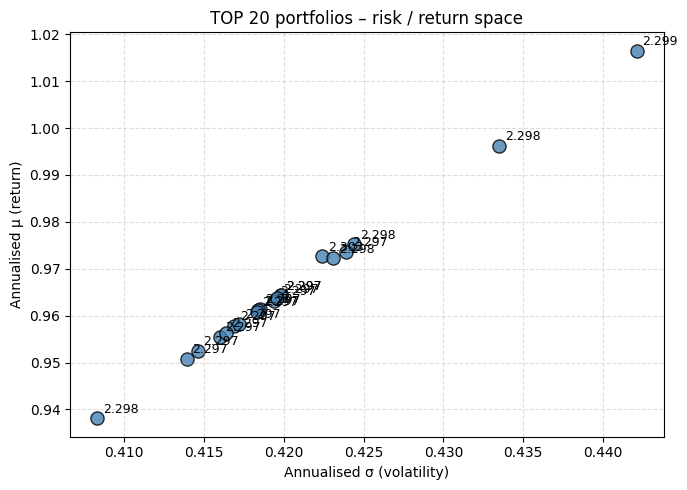

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(top_df['Annual σ'], top_df['Annual μ'],
            s=90, color='steelblue', edgecolors='k', alpha=0.8)

# (по желание) етикет към всяка точка – номерът в класацията
for rank, row in top_df.iterrows():
    plt.annotate(str(row['Sharpe']),
                 (row['Annual σ'], row['Annual μ']),
                 textcoords="offset points",
                 xytext=(4, 4), ha='left', fontsize=9)

plt.xlabel('Annualised σ (volatility)')
plt.ylabel('Annualised μ (return)')
plt.title(f'TOP {len(top_df)} portfolios – risk / return space')
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [13]:
best_w = top_df.iloc[0][tickers].to_dict()
best_w

# ПОРТФЕЙЛ С МАКС. SHARPE
#   Год. доходност : 98.79%
#   Год. волатилност : 60.37%

# BTC	ADA	ALGO	ANKR
# Weight	0.5	0.11	0.09	0.3

# ──────────────────────────────────────────────────────────────────────
# ПОРТФЕЙЛ С МИН. ВОЛАТИЛНОСТ
#   Год. доходност : 90.08%
#   Год. волатилност : 57.66%

# BTC	ADA	ALGO	ANKR
# Weight	0.5	0.31	0.12	0.07

{'BTC': 0.637, 'LINK': 0.067, 'TRX': 0.229, 'ZRX': 0.067}

In [14]:
# -*- coding: utf-8 -*-
"""
Backtrader static-weight portfolio back-test
"""
import matplotlib
matplotlib.use('Agg')  
import backtrader as bt
import pandas as pd
from pathlib import Path


# ---------- Параметри ------------------------------------------------------

WEIGHTS = best_w

DATA_DIR       = Path('../resources/data/raw')   # коригирай пътя, ако е нужно
STARTING_CASH  = 100_000
COMMISSION     = 0.001        # 0.1 %
REBALANCE_DAYS = 30         # напр. 30 за месечен ребаланс


# ---------- Стратегия ------------------------------------------------------

class StaticWeightStrategy(bt.Strategy):
    """
    Поддържа фиксирани тегла. Ребалансира:
      • веднъж на първата свещ;
      • през `rebalance_days`, ако е зададено.
    """
    params = (
        ('weights',         None),
        ('rebalance_days',  None),
    )

    def __init__(self):
        self.rebalanced_init = False     # ще ребалансираме при първата свещ
        self.last_rebalance  = None      # календарно следене (ако е нужно)

    # --------------------------------------------------
    def next(self):
        dt = self.datas[0].datetime.date(0)   # текуща дата

        # --- първоначален ребаланс ---------------------------------
        if not self.rebalanced_init:
            self.rebalance()
            self.rebalanced_init = True
            self.last_rebalance  = dt
            return                          # излизаме, за да не удвоим ребаланса

        # --- периодичен ребаланс -----------------------------------
        if self.p.rebalance_days:
            if (dt - self.last_rebalance).days >= self.p.rebalance_days:
                self.rebalance()
                self.last_rebalance = dt

    # --------------------------------------------------
    def rebalance(self):
        """
        Изравняване на позициите към зададените тегла.
        """
        port_value = self.broker.getvalue()
        for data in self.datas:
            w = self.p.weights.get(data._name, 0.0)
            self.order_target_percent(data=data, target=w)

    # --------------------------------------------------
    def log(self, txt, dt=None):
        pass  # махни 'pass' и сложи print, ако искаш лог


# ---------- Четене на CSV → DataFeed --------------------------------------

def load_feed(path: str | Path, name: str) -> bt.feeds.PandasData:
    """
    Чете 1-minute Binance CSV → ресемплира към дневни свещи.
    """
    df = (
        pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
          .sort_index()
          .resample('1D')
          .agg({'open':'first', 'high':'max', 'low':'min',
                'close':'last', 'volume':'sum'})
          .dropna()
    )

    print(f'{name}: {len(df):>4} дни | {df.index.min().date()} → {df.index.max().date()}')

    return bt.feeds.PandasData(
        dataname=df,
        name=name,
        timeframe=bt.TimeFrame.Days,
        compression=1
    )


# ---------- Cerebro pipeline ----------------------------------------------

cerebro = bt.Cerebro()

# 1) стратегия
cerebro.addstrategy(
    StaticWeightStrategy,
    weights=WEIGHTS,
    rebalance_days=REBALANCE_DAYS
)

# 2) брокер
cerebro.broker.setcash(STARTING_CASH)
cerebro.broker.setcommission(commission=COMMISSION)
#  ➜  BUY/SELL стрелки
cerebro.addobserver(bt.observers.BuySell)     # 📈 показва мястото на всеки ордер
cerebro.addobserver(bt.observers.Trades)      # 💬 балони с резултата от сделката

# 3) данни
cerebro.adddata(load_feed(DATA_DIR / 'BTC_USDT_1m.csv',  'BTC'))
cerebro.adddata(load_feed(DATA_DIR / 'LINK_USDT_1m.csv',  'LINK'))
cerebro.adddata(load_feed(DATA_DIR / 'TRX_USDT_1m.csv',   'TRX'))
cerebro.adddata(load_feed(DATA_DIR / 'ZRX_USDT_1m.csv',   'ZRX'))

# ---------- Бектест --------------------------------------------------------

print(f'\n🟡  Starting Portfolio Value: {cerebro.broker.getvalue():,.2f}')
cerebro.run()
print(f'🟢  Final Portfolio Value:    {cerebro.broker.getvalue():,.2f}')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 20)
figs = cerebro.plot(iplot=True,                 # True = изкарва директно в cell-а
             style='candlestick',
             volume=False,
             barup='lime', bardown='red')
fig = figs[0][0]                              # първият (и единствен) прозорец
fig.savefig('BTC_LINK_TRX_ZRX_assets_backtest_chart.png', dpi=300)    # => ./backtest_chart.png
print('Графиката е записана в backtest_chart.png')
# cerebro.plot(style='candlestick')   # махни коментара за графика


BTC:  366 дни | 2023-06-09 → 2024-06-08
LINK:  366 дни | 2023-06-09 → 2024-06-08
TRX:  366 дни | 2023-06-09 → 2024-06-08
ZRX:  366 дни | 2023-06-09 → 2024-06-08

🟡  Starting Portfolio Value: 100,000.00
🟢  Final Portfolio Value:    219,423.78


<IPython.core.display.Javascript object>

Графиката е записана в backtest_chart.png
